In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
from detector import blur_person
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
%matplotlib inline

Using cache found in C:\Users\virgi/.cache\torch\hub\ultralytics_yolov5_master
requirements: pandas>=1.1.4 not found and is required by YOLOv5, attempting auto-update...
requirements: Command 'pip install 'pandas>=1.1.4' ' returned non-zero exit status 1.
YOLOv5  2022-5-16 Python-3.7.8 torch-1.8.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [2]:
labels = ['Sign '+ str(i) for i in range(1,8)]
fontsize = 14
colors = ['firebrick', 'steelblue']

In [3]:
df = pd.read_csv('results/hand_landmarks.csv')
users = pd.read_csv('users.csv')
train_ids = users[users['train']==1]['user_id'].values
df['train'] = np.where(df['user'].isin(train_ids), 1,0)
df.head()

,user,sex,sign,frame,hand,...,hand_mark_19z,hand_mark_20x,hand_mark_20y,hand_mark_20z,train
0,user01,0,5,4,Right,...,-0.084381,1.000000,0.348559,-0.089569,1
1,user01,0,5,2,Right,...,-0.070153,1.000000,0.274275,-0.073769,1
2,user01,0,1,24,Right,...,-0.050475,0.470683,0.976509,-0.042765,1
3,user01,0,5,3,Right,...,-0.079948,1.000000,0.341380,-0.085815,1
4,user01,0,1,23,Right,...,-0.052067,0.495761,0.972848,-0.044382,1


In [4]:
df_group = df.groupby(['sign','hand','distance']).agg(count=('sign', 'size'), sex=('sex', 'mean')).reset_index()

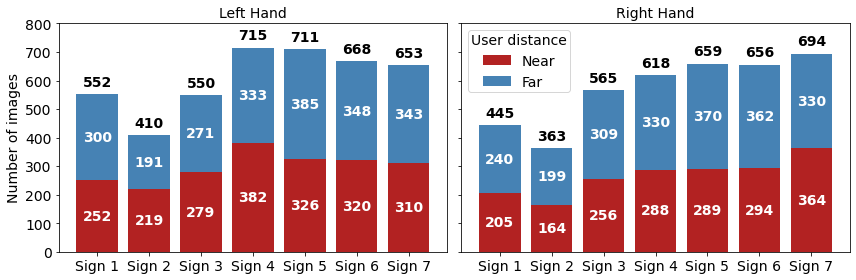

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12, 4), sharey='row')

for hand, i in zip(['Left', 'Right'], range(2)):
    left_hand = df_group[df_group['hand']==hand]
    near_data = left_hand[left_hand['distance']=='Near'].sort_values(by='sign')['count'].values
    far_data = left_hand[left_hand['distance']=='Far'].sort_values(by='sign')['count'].values
    #print(near_data, near_data.sum(), far_data, far_data.sum())

    pn = ax[i].bar(labels, near_data, label='Near', color=colors[0])
    pf = ax[i].bar(labels, far_data, label='Far', bottom=near_data, color=colors[1])
    
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].tick_params(axis='both', which='minor', labelsize=fontsize)

    ax[i].bar_label(pn, label_type='center', fontsize=fontsize, color='white', fontweight='bold')
    ax[i].bar_label(pf, label_type='center', fontsize=fontsize, color='white', fontweight='bold')
    ax[i].bar_label(pf, padding = 5, fontsize=fontsize, fontweight='bold')
    ax[i].set_title(hand+' Hand', fontsize=fontsize)
    ax[i].set_ylim([0,800])

ax[0].set_ylabel('Number of images', fontsize=fontsize)
plt.legend(title='User distance', fontsize=fontsize, title_fontsize=fontsize, borderpad = 0.2)
plt.tight_layout()
plt.savefig('results/img_dataset_hands.pdf', bbox_inches='tight', dpi=300)
plt.show()

c:\users\virgi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator


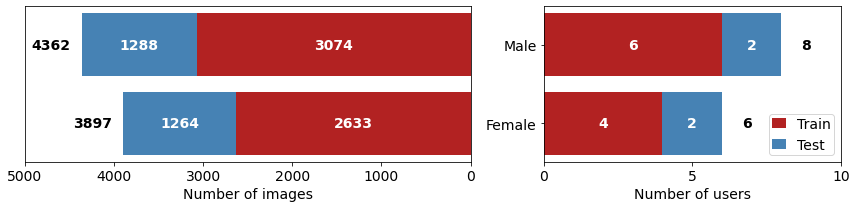

In [7]:
sex_labels = ['Male', 'Female']

fig, ax = plt.subplots(1,2,figsize=(12, 3),gridspec_kw={'width_ratios': [3,2]})

i=0
df_group2 = df.groupby(['sex','train']).agg(count=('sex', 'size')).reset_index()
train_data = df_group2[df_group2['train']==1].sort_values(by='sex')['count'].values
test_data = df_group2[df_group2['train']==0].sort_values(by='sex')['count'].values

pt = ax[i].barh(sex_labels,train_data, label='Train', color=colors[0])
pv = ax[i].barh(sex_labels,test_data, label='Test', left=train_data, color=colors[1])

ax[i].set_xlim([0,5000])
ax[i].invert_yaxis()  # labels read top-to-bottom
ax[i].invert_xaxis()  # labels read top-to-bottom
ax[i].set_yticks([])
ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
ax[i].tick_params(axis='both', which='minor', labelsize=fontsize)

ax[i].bar_label(pt, label_type='center', fontsize=fontsize, color='white', fontweight='bold')
ax[i].bar_label(pv, label_type='center', fontsize=fontsize, color='white', fontweight='bold')
ax[i].bar_label(pv, padding = -50, fontsize=fontsize, fontweight='bold')

ax[i].set_xlabel('Number of images', fontsize=fontsize)


i = 1
df_group3 = df.groupby(['sex','train','user']).agg(count=('sex', 'size')).value_counts(subset=['sex','train']).reset_index()
df_group3.columns = ['sex', 'train', 'count']

train_data = df_group3[df_group3['train']==1].sort_values(by='sex')['count'].values
test_data = df_group3[df_group3['train']==0].sort_values(by='sex')['count'].values

pt = ax[i].barh(sex_labels, train_data, label='Train', color=colors[0])
pv = ax[i].barh(sex_labels, test_data, label='Test', left=train_data, color=colors[1])

ax[i].set_xticks([0, 5,10])
ax[i].invert_yaxis()
ax[i].set_yticklabels(sex_labels,fontsize=fontsize)

ax[i].bar_label(pt, label_type='center', fontsize=fontsize, color='white', fontweight='bold')
ax[i].bar_label(pv, label_type='center', fontsize=fontsize, color='white', fontweight='bold')
ax[i].bar_label(pv, padding = 20, fontsize=fontsize, fontweight='bold')
ax[i].set_xlabel('Number of users', fontsize=fontsize)

ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
ax[i].tick_params(axis='both', which='minor', labelsize=fontsize)

plt.legend(fontsize=fontsize, handlelength=1, borderpad = 0.2)
plt.tight_layout()
plt.savefig('results/img_dataset_train_test.pdf', bbox_inches='tight', dpi=300)

plt.show()

In [8]:
fontsize = 20
user_id = 'user14'
user_images = df[df['user']==user_id]
user_images.head()

,user,sex,sign,frame,hand,...,hand_mark_19z,hand_mark_20x,hand_mark_20y,hand_mark_20z,train
7663,user14,1,1,2,Left,...,-0.033722,0.660072,1.000000,-0.026885,0
7664,user14,1,2,1,Left,...,-0.053339,0.155237,0.153305,-0.048850,0
7665,user14,1,1,3,Left,...,-0.047303,0.551502,0.996175,-0.040551,0
7666,user14,1,1,4,Left,...,-0.040924,0.620083,0.990767,-0.034763,0
7667,user14,1,1,6,Left,...,-0.048214,0.617548,0.983736,-0.042309,0


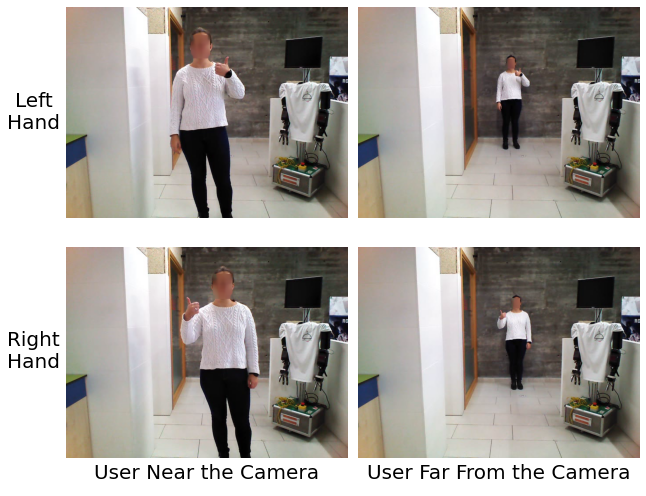

In [9]:
fig, ax = plt.subplots(3,3,figsize=(9,7), gridspec_kw={'width_ratios': [0.75,5,5], 'height_ratios': [5,5,0.1]})

for hand, i in zip(['Left', 'Right'], range(2)):
    for distance, j in zip(['Near', 'Far'], range(1,3)):
        sign=1
        #for sign in range(1,8):
        df_sign = user_images[(user_images['sign']==sign) & (user_images['hand']==hand) & (user_images['distance']==distance)]
        f_name = user_id+'_'+str(df_sign.iloc[1].sex)+'_'+hand[0].lower()+distance[0].lower()+str(sign)+'_'+str(df_sign.iloc[1].frame)+'.png'
        image = cv2.imread(os.path.join('..','images',user_id,f_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_blur = blur_person(image)
        ax[i][j].imshow(image_blur)
        ax[i][j].axis('off')
ax[0][0].axis('off')
ax[0][0].set_title('Left\nHand', y = 0.4, fontsize=fontsize)
ax[1][0].axis('off')
ax[1][0].set_title('Right\nHand', y = 0.4, fontsize=fontsize)
ax[2][0].axis('off')
ax[2][1].axis('off')
ax[2][1].set_title('User Near the Camera', fontsize=fontsize)
ax[2][2].axis('off')
ax[2][2].set_title('User Far From the Camera', fontsize=fontsize)
plt.tight_layout()
plt.savefig('results/img_dataset_distance.pdf', dpi=300)
plt.show()

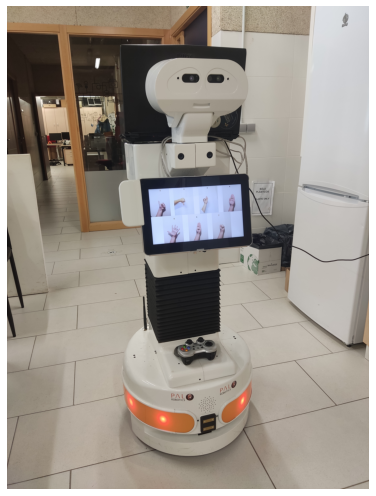

In [10]:
tiago_image = '../tiago_con_signos.jpg'
image = cv2.imread(tiago_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.imshow(image)
ax.axis('off')
plt.tight_layout()
plt.savefig('results/img_tiago.pdf', dpi=300)                 
plt.show()

In [11]:
right_landmarks = [16,18,20,22]
left_landmarks = [15,17,19,21]
def get_hand(image, hand='Left'):
    img_h, img_w, _ = image.shape
    bbox_s=50

    pose =  mp_pose.Pose(static_image_mode=True,model_complexity=2,enable_segmentation=True,min_detection_confidence=0.5)
    result = pose.process(image)   

    if hand == 'Left':
        points = [ [result.pose_landmarks.landmark[i].x,result.pose_landmarks.landmark[i].y] for i in left_landmarks]
    else:
        points = [ [result.pose_landmarks.landmark[i].x,result.pose_landmarks.landmark[i].y] for i in right_landmarks]
    mean_point = [(points[0][0]+points[1][0]+points[2][0])/3, (points[0][1]+points[1][1]+points[2][1])/3]
    hand_point_w = [int(mean_point[0]*img_w), int(mean_point[1]*img_h)]

    image_blur = blur_person(image)
    hand_img = image_blur[hand_point_w[1]-bbox_s:hand_point_w[1]+bbox_s, hand_point_w[0]-bbox_s:hand_point_w[0]+bbox_s]
    return hand_img

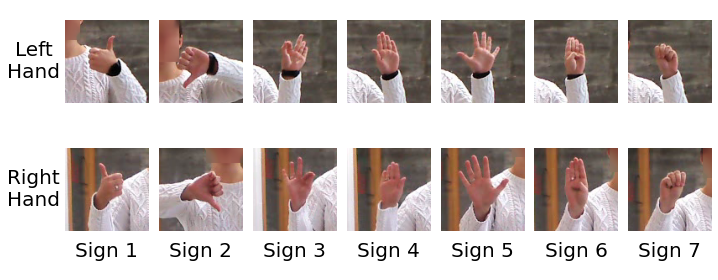

In [12]:
fig, ax = plt.subplots(3,8,figsize=(10,4), gridspec_kw={'width_ratios': [0.5,1,1,1,1,1,1,1], 'height_ratios': [1,1,0.1]})

for hand, i in zip(['Left', 'Right'], range(2)):
    #for distance, j, blur in zip(['Near', 'Far'], range(1,3), [15, 9]):
    for sign in range(1,8):
        df_sign = user_images[(user_images['sign']==sign) & (user_images['hand']==hand) & (user_images['distance']=='Near')]
        f_name = user_id+'_'+str(df_sign.iloc[0].sex)+'_'+hand[0].lower()+'n'+str(sign)+'_'+str(df_sign.iloc[-5].frame)+'.png'
        image = cv2.imread(os.path.join('..','images',user_id,f_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hand_image = get_hand(image, hand)
        #image_blur = blur_person(image,blur)
        ax[i][sign].imshow(hand_image)
        ax[i][sign].axis('off')
        
        ax[2][sign].axis('off')
        ax[2][sign].set_title('Sign '+str(sign), fontsize=fontsize)
ax[0][0].axis('off')
ax[0][0].set_title('Left\nHand', y = 0.3, fontsize=fontsize)
ax[1][0].axis('off')
ax[1][0].set_title('Right\nHand', y = 0.3, fontsize=fontsize)
ax[2][0].axis('off')

ax[2][2].axis('off')
plt.tight_layout()
plt.savefig('results/img_dataset_signs.pdf', dpi=300)
plt.show()